# 📈 Checkpointing

This notebook shows how to train a model and load it from a checkpoint.

## Setup 

In [1]:
import autorootcwd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import time
import torch
from transformers import AutoModelForCausalLM

## Learning Rate Scheduler

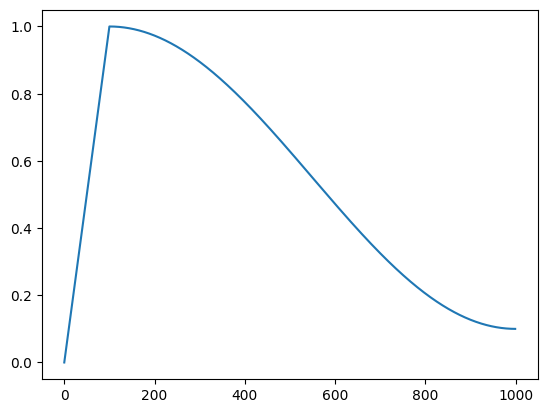

In [3]:
def lr_lambda(step, warmup_steps, num_steps, num_cycles, min_lr_factor):
    if step < warmup_steps:
        return step / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, num_steps - warmup_steps)
    cosine_decay = 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress))
    return min_lr_factor + (1 - min_lr_factor) * cosine_decay

steps = 1000
xs = np.arange(0, steps)
plt.plot(xs, [lr_lambda(x, 100, steps, 0.5, 0.1) for x in xs])
plt.show()

## Mixed Precision

In [4]:
gpt2 : AutoModelForCausalLM = AutoModelForCausalLM.from_pretrained("mikasenghaas/gpt2-124m-fresh").to("cuda")

print(f"Loaded model with {gpt2.num_parameters()/1e6:.2f}M parameters")

Loaded model with 124.44M parameters


In [5]:
# Micro batch
B, L, V = 8, 1024, 50257
x = torch.randint(0, V, (B, L+1), dtype=torch.long).to("cuda")
batch = {"input_ids": x[:, :-1], "attention_mask": torch.ones_like(x[:, :-1]), "labels": x[:, 1:]}

### Highest Precision

In [6]:
torch.set_float32_matmul_precision("highest")

In [7]:
%%timeit -n 5 -r 5
outputs = gpt2(**batch)
outputs.loss.backward()

256 ms ± 10.2 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [8]:
%%timeit -n 5 -r 5
with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    outputs = gpt2(**batch)
outputs.loss.backward()

150 ms ± 14.1 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [9]:
%%timeit -n 5 -r 5
with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
    outputs = gpt2(**batch)
outputs.loss.backward()

145 ms ± 3.58 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


Hence, we get a 1.7x speedup with using `float16` or `bfloat16`. We prefer `bfloat16` because it has no precision loss.

### High Precision

In [10]:
torch.set_float32_matmul_precision("high")

In [11]:
%%timeit -n 5 -r 5
outputs = gpt2(**batch)
outputs.loss.backward()

211 ms ± 6.91 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [12]:
%%timeit -n 5 -r 5
with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    outputs = gpt2(**batch)
outputs.loss.backward()

146 ms ± 6.15 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [13]:
%%timeit -n 5 -r 5
with torch.amp.autocast(device_type="cuda", dtype=torch.bfloat16):
    outputs = gpt2(**batch)
outputs.loss.backward()

143 ms ± 377 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


Hence, we get a 1.2x speedup compared to "highest". Together, with `float16` or `bfloat16`, we get a 1.8x speedup.